# using pycwr for Radar io

## read Radar basedata

In [1]:
%matplotlib inline
from pycwr.io import read_auto

In [2]:
PRD = read_auto(r"E:\RadarBaseData\WSR98D\Z9898\Z_RADR_I_Z9898_20190828181529_O_DOR_SAD_CAP_FMT.bin.bz2")

In [3]:
PRD.scan_info

<xarray.Dataset>
Dimensions:            (sweep: 9)
Coordinates:
  * sweep              (sweep) int32 0 1 2 3 4 5 6 7 8
Data variables:
    latitude           float64 20.0
    longitude          float64 110.2
    altitude           int32 118
    scan_type          <U3 'ppi'
    frequency          float64 2.73
    start_time         datetime64[ns] 2019-08-28T18:16:02.393134
    end_time           datetime64[ns] 2019-08-28T18:21:01.712371
    nyquist_velocity   (sweep) float32 27.83 27.83 ... 32.416397 32.416397
    unambiguous_range  (sweep) int32 300000 300000 146000 ... 124000 124000
    rays_per_sweep     (sweep) int64 361 361 363 362 363 361 364 364 364
    fixed_angle        (sweep) float32 0.48339844 1.4941406 ... 19.511719
    beam_width         (sweep) float64 0.9972 0.9972 0.9917 ... 0.989 0.989

In [4]:
PRD.fields[0]

<xarray.Dataset>
Dimensions:    (range: 1200, time: 361)
Coordinates:
    azimuth    (time) float64 285.3 286.2 287.2 288.2 ... 283.1 284.1 285.1
    elevation  (time) float64 0.48 0.48 0.48 0.48 0.48 ... 0.52 0.52 0.52 0.52
    x          (time, range) float64 -241.2 -482.3 ... -2.891e+05 -2.894e+05
    y          (time, range) float64 65.84 131.7 197.5 ... 7.813e+04 7.819e+04
    z          (time, range) float64 238.1 240.2 242.3 ... 8.241e+03 8.252e+03
    lat        (time, range) float64 20.0 20.0 20.0 20.0 ... 20.68 20.68 20.68
    lon        (time, range) float64 110.2 110.2 110.2 ... 107.5 107.5 107.5
  * range      (range) float64 250.0 500.0 750.0 ... 2.995e+05 2.998e+05 3e+05
  * time       (time) datetime64[ns] 2019-08-28T18:16:02.393134 ... 2019-08-28T18:16:25.134606
Data variables:
    V          (time, range) float64 nan nan nan nan -5.5 ... nan nan nan nan
    W          (time, range) float64 nan nan nan nan 1.0 ... nan nan nan nan nan
    dBT        (time, range) float64 nan nan nan nan 34.0 ... nan nan nan nan
    dBZ        (time, range) float64 nan nan nan nan -7.5 ... nan nan nan nan
    SQI        (time, range) float64 nan nan nan nan 0.93 ... nan nan nan nan
    ZDR        (time, range) float64 nan nan nan nan 0.93 ... nan nan nan nan
    CC         (time, range) float64 nan nan nan nan 0.88 ... nan nan nan nan
    PhiDP      (time, range) float64 nan nan nan nan 32.98 ... nan nan nan nan
    KDP        (time, range) float64 nan nan nan nan nan ... nan nan nan nan nan
    SNRH       (time, range) float64 nan nan nan nan 34.0 ... nan -7.5 nan nan

## using pycwr with Py-ART

In [5]:
import pyart
import matplotlib.pyplot as plt
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [6]:
pyart_radar = PRD.ToPyartRadar()

C:\Users\zy\Anaconda3\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


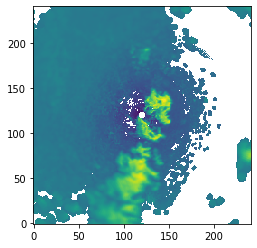

In [7]:
pyart_radar.fields['reflectivity']['data'][:, -10:] = np.ma.masked

# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(pyart_radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (pyart_radar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 241, 241),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['reflectivity'])

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
plt.show()

## save as cfradial format

In [8]:
pyart.io.write_cfradial("cfradial.nc", pyart_radar)